In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
%matplotlib inline

# Omnifold: Multi-dimensional unbinned unfolding
Content borrowed from [Vinicius Mikuni](https://github.com/usatlas-ml-training/lbnl-2023/blob/main/unfolding/DIS_Omnifold-sol.ipynb), many thanks to him!

In [2]:
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K

def reweight(events, model, batch_size=10000):
    f = model.predict(events, batch_size=batch_size)
    weights = ??
    return np.squeeze(np.nan_to_num(weights))


# Binary crossentropy for classifying two samples with weights
# Weights are "hidden" by zipping in y_true (the labels)


def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1)  # event weights
    y_true = tf.gather(y_true, [0], axis=1)  # actual y_true for loss

    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)

    #binary crossentropy
    t_loss = -weights * ((y_true) * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))

    return K.mean(t_loss)


In [ ]:
def omnifold(theta0_G, theta0_S, theta_unknown_S, iterations, model, verbose=0):
    if any(len(lst) != len(theta0_S) for lst in [theta0_S, theta0_G, theta_unknown_S]):
        print("all inputs must be of same length")
        exit

    weights = np.empty(shape=(iterations, 2, len(theta0_S)))
    # shape = (iteration, step, event)

    labels0 = np.zeros(len(theta0_S))  # synthetic theta0_S label = 0
    labels_unknown = np.ones(len(theta_unknown_S))  # data, theta_unknown_S

    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))

    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels_unknown))

    # initial iterative weights are ones
    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))

    for i in range(iterations):
        print(f"\nITERATION: {i + 1}\n")

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data

        print("STEP 1\n")
        pass

        weights_1 = np.concatenate((weights_push, np.ones(len(theta_unknown_S))))

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(xvals_1, yvals_1, weights_1)

        # zip ("hide") the weights with the labels
        Y_train_1 = np.stack((Y_train_1, w_train_1), axis=1)
        Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)

        model.compile(loss=weighted_binary_crossentropy, optimizer='Adam', metrics=['accuracy'])

        model.fit(X_train_1, Y_train_1, epochs=40, batch_size=1000, validation_data=(X_test_1, Y_test_1), verbose=verbose)

        weights_pull = weights_push * reweight(theta0_S, model)
        weights[i, 0, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.

        print("\nSTEP 2\n")
        pass

        weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
        # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(xvals_2, yvals_2, weights_2)

        # zip ("hide") the weights with the labels
        Y_train_2 = np.stack((Y_train_2, w_train_2), axis=1)
        Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)

        model.compile(loss=weighted_binary_crossentropy, optimizer='Adam', metrics=['accuracy'])
        model.fit(X_train_2, Y_train_2, epochs=40, batch_size=1000, validation_data=(X_test_2, Y_test_2), verbose=verbose)

        weights_push = reweight(theta0_G, model)
        weights[i, 1, :] = weights_push
        pass

    return weights

### Something seems wrong in above definition of omnifold, what is it?

# Now generate toy data

|   |   |   |
|---|---|---|
|Synthetic Generator-Level Sim   | $\theta_{0,G}$  | Truth-Level Sim  |
|Synthetic Reconstruction-Level Sim   | $\theta_{0,S}$   | Full Reco-Level Sim  |
|Natural Reconstruction  | $\theta_\mathrm{unknown,S}$  | Observed Detector Data  |
|Natural Truth   |$\theta_\mathrm{unknown,G}$   | Nature  |


In [3]:
N_Events = 10**5

# Synthetic
theta0_G = np.random.normal(0.2, 0.8, N_Events)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, 0.5)) for x in theta0_G])  # Detector smearing for synthetic sample

theta0 = np.stack([theta0_G, theta0_S], axis=1)

# Natural
theta_unknown_G = np.random.normal(0, 1, N_Events)
theta_unknown_S = np.array([(x + np.random.normal(0, 0.5)) for x in theta_unknown_G])

## Notice:
    - Data truth and MC truth are not the same, there is a sim bias to overcome
    - Detector smearing is the same for both
    - We can _never_ use data truth in unfolding procedure

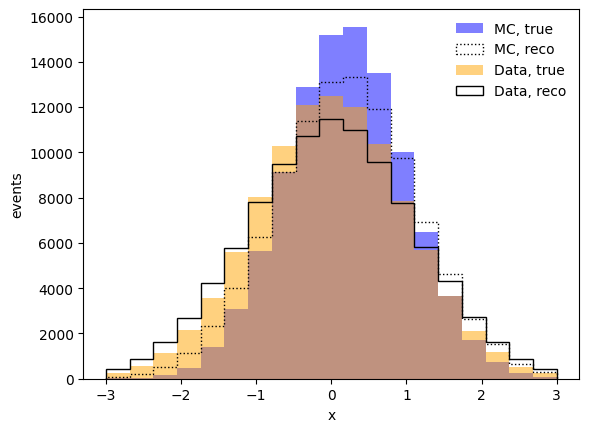

In [4]:
_, _, _ = plt.hist(theta0_G, bins=np.linspace(-3, 3, 20), color='blue', alpha=0.5, label="MC, true")
_, _, _ = plt.hist(theta0_S, bins=np.linspace(-3, 3, 20), histtype="step", color='black', ls=':', label="MC, reco")
_, _, _ = plt.hist(theta_unknown_G, bins=np.linspace(-3, 3, 20), color='orange', alpha=0.5, label="Data, true")
_, _, _ = plt.hist(theta_unknown_S, bins=np.linspace(-3, 3, 20), histtype="step", color='black', label="Data, reco")
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False)

### Define the Model Architecture

In [5]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model


inputs = Input((1,))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model_gaus = Model(inputs=inputs, outputs=outputs)

In [8]:
N_Iterations = 2
myweights = omnifold(??, ??, ??, N_Iterations, model_gaus)


ITERATION: 1

STEP 1

10/10 [==============================] - 0s 1ms/step

STEP 2

10/10 [==============================] - 0s 984us/step

ITERATION: 2

STEP 1

10/10 [==============================] - 0s 1ms/step

STEP 2

10/10 [==============================] - 0s 1ms/step


### Plot unfolded distributions

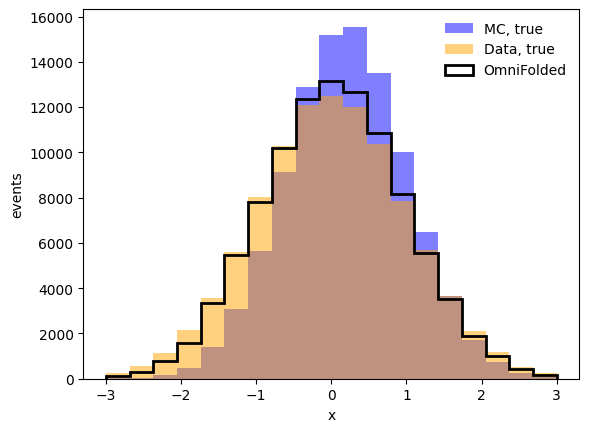

In [9]:
_, _, _ = plt.hist(theta0_G, bins=np.linspace(-3, 3, 20), color='blue', alpha=0.5, label="MC, true")
_, _, _ = plt.hist(theta_unknown_G, bins=np.linspace(-3, 3, 20), color='orange', alpha=0.5, label="Data, true")
_, _, _ = plt.hist(
    theta0_G,
    weights=myweights[?, ?, :], #  shape = (iteration, step, event)
    bins=np.linspace(-3, 3, 20),
    color='black',
    histtype="step",
    label="OmniFolded",
    lw=2,
)
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False)

### Plot the distribution at reco level instead of gen level

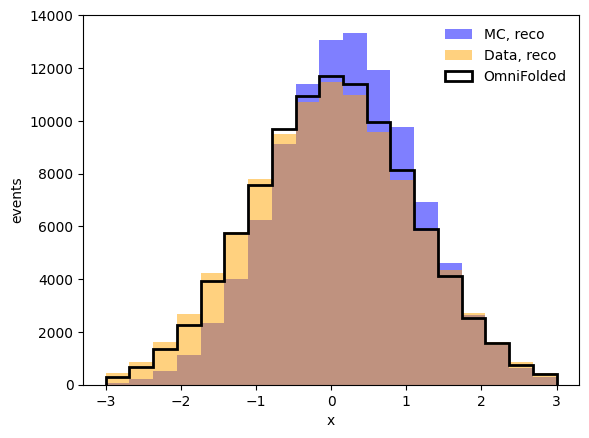

In [10]:
_,_,_=plt.hist(theta0_S,bins=np.linspace(-3,3,20),color='blue',alpha=0.5,label="MC, reco")
_,_,_=plt.hist(theta_unknown_S,bins=np.linspace(-3,3,20),color='orange',alpha=0.5,label="Data, reco")
_,_,_=plt.hist(theta0_S,weights=myweights[-1, 1, :],
               bins=np.linspace(-3,3,20),color='black',histtype="step",label="OmniFolded",lw=2)
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False)

# Physics data: Realistic DIS Reconstruction – Lepton + HFS
Samples from [this paper], (https://www.sciencedirect.com/science/article/pii/S0168900221010445?ref=cra_js_challenge&fr=RR-1)

We treat 'Django' as 'data' and 'Rapgap' as our synthetic simulations.

In [11]:
import h5py as h5
import os

### Place the folder downloaded from [here](https://cernbox.cern.ch/s/JEqm8fWwUo0EBoc) in SBITutorial directory

In [12]:
path_to_file = 'unfoldingData/'
natural_file = h5.File(os.path.join(path_to_file, "django.h5"), "r")  # Proxy for the data we are going to use for unfolding
synthetic_file = h5.File(
    os.path.join(path_to_file, "rapgap.h5"), "r"
)  # Proxy for the data we are going to use for unfolding

In [13]:
obs_features = ["obs_hfs_pt", "obs_hfs_eta", "obs_e_e", "obs_e_pz", "obs_e_eta"]
gen_features = ["gen_hfs_pt", "gen_hfs_eta", "gen_e_e", "gen_e_pz", "gen_e_eta"]

labels = ["HFS $p_\mathrm{T}$ [GeV]", "HFS $\eta$", "Electron $E$ [GeV]", "Electron $p_z$", "Electron $\eta$"]

In [14]:
def dis_preprocessing(events, mean=None, std=None):
    "input features are obs_hfs_pt", "obs_hfs_eta", "obs_e_e", "obs_e_pz", "obs_e_eta, let's do a simple standardization"
    new_data = np.copy(events)
    new_data[:, 0] = np.log(new_data[:, 0])
    new_data[:, 2] = np.log(new_data[:, 2])

    if mean is None:
        mean = np.mean(new_data, 0, keepdims=True)
        std = np.std(new_data, 0, keepdims=True)

    return (new_data - mean) / std, mean, std

In [15]:
theta_unknown_S = np.stack([natural_file[feat] for feat in obs_features], -1)  # Reconstructed Data
theta_unknown_G = np.stack([natural_file[feat] for feat in gen_features], -1)  # Nature, which unfolded data approaches

theta0_S = np.stack([synthetic_file[feat] for feat in obs_features], -1)  # Simulated, synthetic reco-level
theta0_G = np.stack([synthetic_file[feat] for feat in gen_features], -1)  # Generated, synthetic truth-level

# Let's remove empty entries
mask_data = theta_unknown_S[:, 0] != 0
theta_unknown_S = theta_unknown_S[mask_data]
theta_unknown_G = theta_unknown_G[mask_data]

mask_MC = theta0_S[:, 0] != 0
theta0_S = theta0_S[mask_MC]
theta0_G = theta0_G[mask_MC]

### For simplicity, let's have the same number of events for both data and MC

In [16]:
N_Events = int(1e6)
theta0_S = theta0_S[:N_Events]
theta0_G = theta0_G[:N_Events]
theta_unknown_S = theta_unknown_S[:N_Events]
theta_unknown_G = theta_unknown_G[:N_Events]

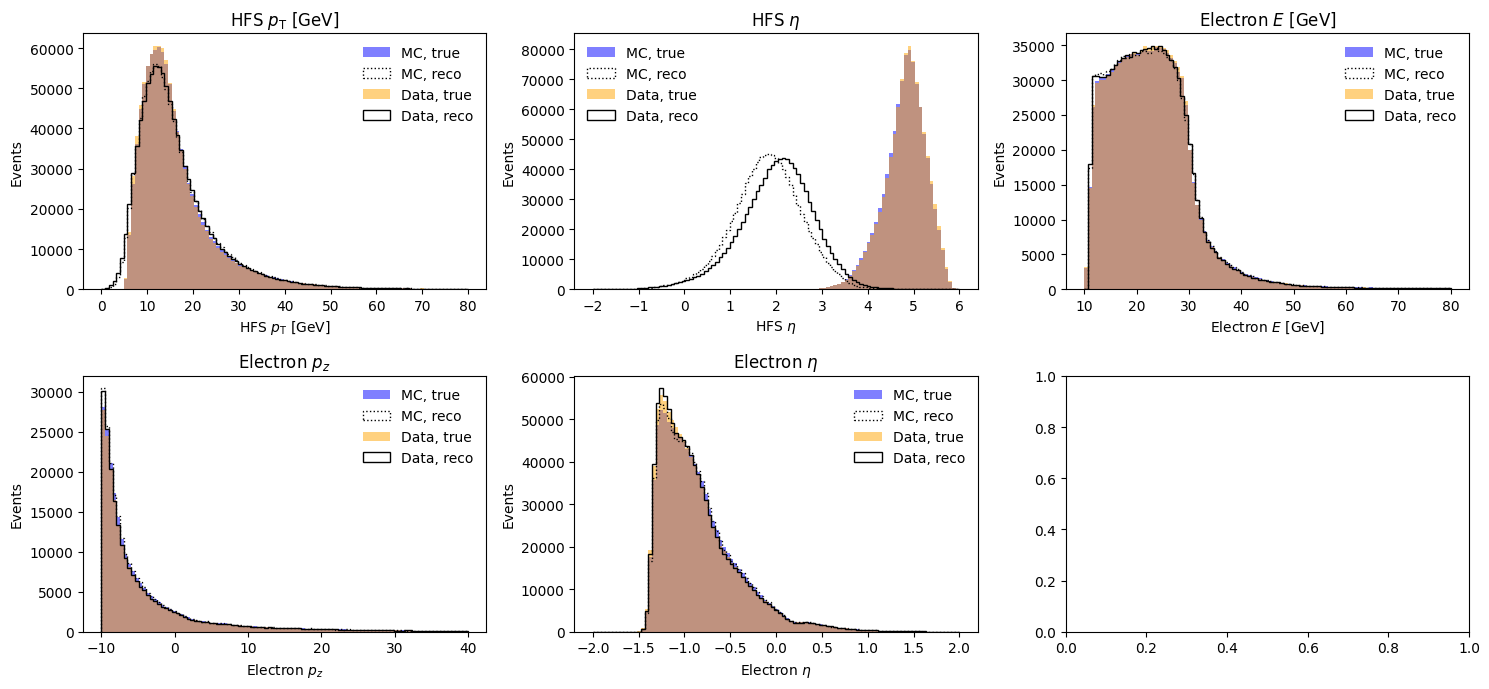

In [17]:
N = len(obs_features)

binning = [
    np.linspace(0, 80, 100),
    np.linspace(-2, 6, 100),
    np.linspace(10, 80, 100),
    np.linspace(-10, 40, 100),
    np.linspace(-2, 2, 100),
]

fig, axes = plt.subplots(2, 3, figsize=(15, 7))

for i, ax in enumerate(axes.ravel()):
    if i >= N:
        break
    _, _, _ = ax.hist(theta0_G[:, i], binning[i], color='blue', alpha=0.5, label="MC, true")
    _, _, _ = ax.hist(theta0_S[:, i], binning[i], histtype="step", color='black', ls=':', label="MC, reco")
    _, _, _ = ax.hist(theta_unknown_G[:, i], binning[i], color='orange', alpha=0.5, label="Data, true")
    _, _, _ = ax.hist(theta_unknown_S[:, i], binning[i], histtype="step", color='black', label="Data, reco")

    ax.set_title(labels[i])
    ax.set_xlabel(labels[i])
    ax.set_ylabel("Events")
    ax.legend(frameon=False)

fig.tight_layout()

### Define model

In [18]:
inputs = Input((len(obs_features),))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(100, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model_dis = Model(inputs=inputs, outputs=outputs)

In [ ]:
N_Iterations = 4
# Normalize the data before training
theta0_G_norm, _, _ = dis_preprocessing(theta0_G)
theta0_S_norm, mean, std = dis_preprocessing(theta0_S)
theta_unknown_S_norm, _, _ = dis_preprocessing(
    theta_unknown_S, mean, std
)  # We want to use the same mean and std applied to MC here

# OmniFold returns an array of weights with shape [N_iterations,2,N] with the weights for each iteration in step 1 and 2
myweights = omnifold(theta0_G_norm, theta0_S_norm, 
                     theta_unknown_S_norm, N_Iterations, ??)


ITERATION: 1

STEP 1

100/100 [==============================] - 0s 990us/step

STEP 2

100/100 [==============================] - 0s 1ms/step

ITERATION: 2

STEP 1

100/100 [==============================] - 0s 1ms/step

STEP 2

100/100 [==============================] - 0s 1ms/step

ITERATION: 3

STEP 1

100/100 [==============================] - 0s 1ms/step

STEP 2



In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 7))

gen_binning = [
    np.linspace(3, 40, 100),
    np.linspace(3, 6, 100),
    np.linspace(5, 50, 100),
    np.linspace(-25, 10, 100),
    np.linspace(-1.8, 1.0, 100),
]

for i, ax in enumerate(axes.ravel()):
    if i >= N:
        break
    _, _, _ = ax.hist(theta0_G[:, i], gen_binning[i], color='blue', alpha=0.5, label="MC, true", density=True)
    _, _, _ = ax.hist(theta_unknown_G[:, i], gen_binning[i], color='orange', alpha=0.5, label="Data, true", density=True)
    _, _, _ = ax.hist(
        theta0_G[:, i],
        weights=myweights[-1, 1, :],
        bins=gen_binning[i],
        color='black',
        histtype="step",
        label="OmniFolded",
        lw=2,
        density=True,
    )

    ax.set_title(labels[i])
    ax.set_xlabel(labels[i])
    ax.set_ylabel("Normalized events")
    ax.legend(frameon=False)

fig.tight_layout()

# Create new observables that were not explicitly unfolded

### 1. Plot _unfolded_ electron observables: $\Sigma_e = E_e - p_{z,e}, \ \ \theta = 2\arctan(e^{-\eta})$

In [ ]:
# let's create these variables
sigma_e = ??
theta = ??



In [ ]:
sigma_e_truth = theta_unknown_G[:, 2] - theta_unknown_G[:, 3]
theta_truth = 2 * np.arctan(np.exp(-theta_unknown_G[:, 4]))

In [ ]:
# Now plot!
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

binning = [np.linspace(3, 60, 50), np.linspace(0, 3.14, 50)]
to_plot = [sigma_e, theta]
to_plot_truth = [sigma_e_truth, theta_truth]
names = [r'$\Sigma_e$ GeV', r'$\theta$']

for i, ax in enumerate(axes.ravel()):
    _, _, _ = ax.hist(to_plot[i], binning[i], color='blue', alpha=0.5, label="MC, true", density=True)
    _, _, _ = ax.hist(to_plot_truth[i], binning[i], color='orange', alpha=0.5, label="Data, true", density=True)
    _, _, _ = ax.hist(
        to_plot[i],
        weights=myweights[-1, 1, :],
        bins=binning[i],
        color='black',
        histtype="step",
        label="OmniFolded",
        lw=2,
        density=True,
    )

    ax.set_title(names[i])
    ax.set_xlabel(names[i])
    ax.set_ylabel("Normalized events")
    ax.legend(frameon=False)

fig.tight_layout()